In [7]:
from qiskit import *
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from IPython.display import display, Image
from qiskit.visualization import plot_histogram

In [8]:
def murder(n):
    q = range(n)
    logic = QuantumRegister(n)
    logic = QuantumCircuit(logic, name="murder")
    # q0 is Maid
    # q1 is Butler
    # q2 is Gardener
    # q3 is the result
    logic.x(1)
    logic.ccx(0, 1, 4)
    logic.ccx(0, 2, 5)
    logic.x([4, 5])
    logic.ccx(4, 5, 3)
    # return q4, q5
    logic.x([4, 5])
    logic.ccx(0, 2, 5)
    logic.ccx(0, 1, 4)
    logic.barrier(q)
    logic.x(0)
    logic.ccx(0, 2, 6)
    logic.x(2)
    logic.mcx([0, 1, 2], 4)
    logic.x(1)
    logic.mcx([0, 1, 2], 5)
    logic.barrier(q)
    logic.x([4, 5, 6])
    logic.ccx(4, 5, 7)
    logic.ccx(7, 6, 3)
    # return q4, q5, q6
    logic.ccx(4, 5, 7)
    logic.x(5)
    logic.mcx([0, 1, 2], 5)
    logic.x(1)
    logic.x(4)
    logic.mcx([0, 1, 2], 4)
    logic.x(2)
    logic.x(6)
    logic.ccx(0, 2, 6)
    logic.x(0)
    # left over q1 at the beginning
    logic.barrier(q)
    logic.x(1)

    return logic.to_instruction()

In [9]:
def diffuser(n):
    logic = QuantumRegister(n)
    logic = QuantumCircuit(logic, name="diffuser")
    q = range(n)
    # Step 1: Apply Hadamard and X to all qubits
    logic.h(q)
    logic.x(q)
    logic.barrier(q)
    # Step 3: Apply multi-controlled Z gate
    # This is equivalent to a controlled-Z gate with n-1 controls
    logic.h(n - 1)
    logic.mcx(list(range(n - 1)), n - 1)
    logic.h(n - 1)
    logic.barrier(q)
    # Step 4: Apply X and H to all qubits again
    logic.x(q)
    logic.h(q)
    return logic.to_instruction()

In [10]:
def solver(n_qubit=8, output=3, iter=1, out_res=False):
    q = range(n_qubit)
    o = range(output)
    expect_out = output + 1 if out_res else output
    qc = QuantumCircuit(n_qubit, expect_out)
    qc.h(o)
    qc.x(output)
    qc.h(output)
    qc.barrier(q)
    for _ in range(iter):
        qc.append(murder(n_qubit), q)
        qc.barrier(q)
        qc.append(diffuser(output), o)
    qc.barrier(q)
    if out_res:
        qc.measure(range(output + 1), range(output + 1))
    else:
        qc.measure(o, o)
    return qc

In [11]:
def analyse(qc):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()
    total_counts = sum(counts.values())
    probs = {key: value / total_counts for key, value in counts.items()}
    fig = plot_histogram(probs, title="Quantum")
    fig.savefig("grover_murder_chart")
    # fig.show()
    filtered_counts = {
        key: value
        for key, value in counts.items()
        if 1000 < int(key) < 1111
        and int(key) not in {1100, 1010, 1001}
        and int(key) not in {1, 100, 10, 0, 111}
    }
    for key, value in filtered_counts.items():
        print(f"{key}: {value}")

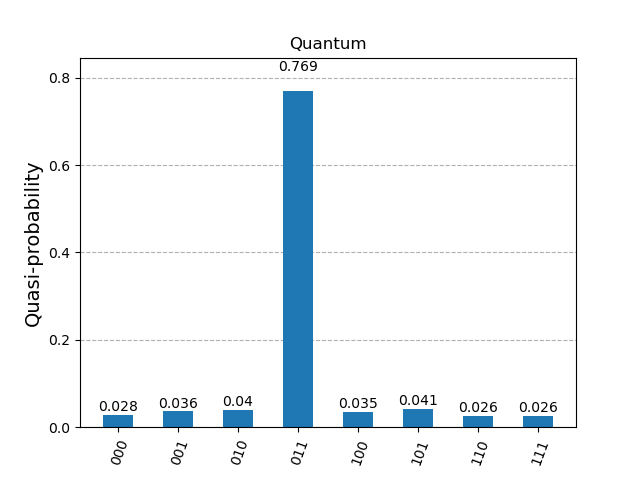

In [34]:
qc = solver(out_res=False, iter=1)
qc.draw("mpl", scale=0.5)
analyse(qc)
img = Image("grover_murder_chart.png", width=500)
display(img)